In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from networkx.algorithms import bipartite
from surprise import SVD, KNNBasic, Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split, KFold, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts

%matplotlib inline

In [ ]:
df = pd.read_csv('bigframe.csv')

# to avoid unamed:0, read_csv with index_col=0

In [35]:
def test_last_split(df, last_x=1):
    '''
    Split trainset to be all but last one, or more, of
    each User's profile of checkins, chronologically, and then
    test on the most recent checkin(s).
    --------------
    Inputs--
    
    df:  DataFrame with rows of User/Beer/Rating combos, a.k.a. 'checkins', 
        chronologically ordered, but not necessarily user-ordered
    
    last_x:  how many rows to use for testing.  defaults to 1, the most recent checkin.
    
    --------------
    Returns-- A User-stratified split into training and testing 
    
    '''
    
    trainers = []
    testers = []
    
    # Loop over each user in the DataFrame input
    for u in df.user_id.unique():
        udf = df[df.user_id == u]
        n_ratings = len(udf)
        # use the @last_x integer, default=1, of each user's checkins as the test group
        split = n_ratings - last_x  # (first) index of test rating(s)
        trainers.append(udf.iloc[:split, :])  # train-test split
        testers.append(udf.iloc[split:, :])

    return trainers, testers

In [4]:
df.shape

(1425447, 27)

In [5]:
df.columns

Index(['Unnamed: 0', 'checkin_id', 'beer_id', 'user_id', 'rating_user',
       'brewery_name', 'beer_name', 'beer_style', 'brewery_id', 'brewery_type',
       'brewery_country', 'brewery_city', 'brewery_state', 'brewery_lat',
       'brewery_lon', 'venue_lat', 'venue_lon', 'venue_city', 'venue_country',
       'venue_state', 'venue_cat', 'venue_id', 'checkin_comment', 'venue_type',
       'rating_global', 'abv', 'date'],
      dtype='object')

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.shape

(1425447, 26)

#### Remove all but the most recent one User/Beer combo for multiple such checkins

In [8]:
df.drop_duplicates(subset=['user_id', 'beer_id'], inplace=True)  # keep_first (default) means keep most recent checkin

df.shape  # remaining from 1.42M prev

(1296064, 26)

#####  drop all checkins without global ratings, since we need those ratings and would have them in normal prediction scenarios.

In [24]:
df = df[df.rating_global > 0]
df.shape

(1089604, 26)

=====================================================================================================================

The best results below come from a simple baseline mean, where each user has a "generosity" score for how she rates beers compared to the average user, and each beer has a similar score for how it rates compared to the mean.  But those user and beer biases include all beers, so let's see how they do with just a train set/ test set type of split.

In [12]:
# make the split before calculating biases, to see how the results fare
trainers, testers = tts(df, test_size=0.02, random_state=0)

In [13]:
testers.shape

(21793, 26)

In [14]:
# the global rating for each beer differs slightly from checkin to checkin,
## due to accumulating stats over time.  Also I'm using each beer's listed
## global rating mean, instead of the mean of all global ratings...
beer_mu = dict(trainers.groupby('beer_id').rating_global.mean())

In [15]:
trainers['user_bias'] = trainers.rating_user - trainers.rating_global
userbiasdict = dict(trainers.groupby('user_id').user_bias.mean())

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### for the testers that have user and beer in the trainers, predict and score rmse

In [58]:
preds = []
actual = []
for i in testers.index:
    try:
        preds.append(beer_mu[testers.loc[i, 'beer_id']] +
                     userbiasdict[testers.loc[i, 'user_id']])
        actual.append(testers.loc[i, 'rating_user'])
    except KeyError:
        continue

In [59]:
assert len(preds) == len(actual)

In [60]:
diffs = np.array(preds) - np.array(actual)
rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
rmse

0.43718955477433807

In [17]:
# How generous are the data users versus global raters
trainers.user_bias.mean()

0.0028213614300656525

In [16]:
# how does a rating differ from what you'd expect for the given user and beer?
#  trainers.user_bias - userbiasdict['user_id']
trainers['deviation'] = trainers.user_bias - [userbiasdict[u] for u in trainers.user_id]

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
trainers['abs_dev'] = trainers.deviation.abs()

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
from scipy.stats import pearsonr

In [20]:
a = np.array([0.2,0,-0.1,0.3,-0.05,-0.09])
b = np.array([0.04,.3,-.1,.1,0,-.1])
pearsonr(a,b)

(0.3730348371762281, 0.46640257370694121)

Make graph representations of user rating biases in an attempt to identify similar/dissimilar users

In [22]:
udict = {uid:dict() for uid in trainers.user_id.unique()}
bdict = {bid:dict() for bid in trainers.beer_id.unique()}
for checkin in zip(trainers.user_id, trainers.beer_id, trainers.deviation):
    udict[checkin[0]][checkin[1]] = checkin[2]
    bdict[checkin[1]][checkin[0]] = checkin[2]
    

In [23]:
from collections import defaultdict

In [24]:
# calculate user/user correlation/similarity 
shared = {u: defaultdict(lambda: defaultdict(float)) for u in udict}

In [25]:
# this takes an hour +-, with the nested loops, but seems messy otherwise
for u in tqdm(udict):
    # loop thru all checkins by u
    for b in udict[u]:
        # update the similarity factors for u-v for every checkin, as would happen with new checkins
        for v in bdict[b]:
            suv = shared[u][v]
            suv['count'] += 1  # increment the common u-v ratings
            #### stats.stackexchange has these going last, but then each new sample
            ##### updates to a diff from mean that it contributes to, which seems wrong
            ###### (and messes up the first one, where u_bar == u[b])  ####
            u_dev = udict[u][b] - suv['u_bar']
            v_dev = udict[v][b] - suv['v_bar']
            suv['numer'] += u_dev * v_dev
            suv['denom_1'] += u_dev ** 2
            suv['denom_2'] += v_dev ** 2
            #####
            suv['u_bar'] = ((suv['count']-1) * suv['u_bar'] + udict[u][b]) / suv['count']
            suv['v_bar'] = ((suv['count']-1) * suv['v_bar'] + udict[v][b]) / suv['count']
            
    # remove self-edges
    del shared[u][u]

100%|██████████| 7896/7896 [2:09:43<00:00,  1.01it/s]     


In [26]:
len(shared[206343])

4771

In [48]:
preds = []
actual = []
lam_4 = 25   # penalizes similarity scores based on few ratings
lam_5 = 10  # cuts down on similarity influence on final prediction
k = 2   # most similar or dissimilar raters
eps = 1e-10  # occasional division by zero computing pearson
start = 0  # index for testing
end = len(testers)  # index for testing

for row in tqdm(zip(testers.user_id[start:end], 
                    testers.beer_id[start:end], 
                    testers.rating_user[start:end])):
    try:
        x = row[1]  # beer
        u = row[0]  # user
        baseline = beer_mu[x] + userbiasdict[u]   # global rating for the beer plus user bias
        # only looking for users v who rated the beer x in question
        uv = [v for v in bdict[x] if v in shared[u]]
        if not uv:  # sometimes there's no one in the training set who has common beers with user
            preds.append(baseline)
            actual.append(row[2])
            continue
        suv = [shared[u][v] for v in uv]
        # first get u-v pearsons
        ## https://stats.stackexchange.com/questions/410468/online-update-of-pearson-coefficient
        sims = [s['numer'] / (np.sqrt(s['denom_1'] * s['denom_2'] + eps))
                    for s in suv]  
        # then shrink in relation to number of common u-v ratings
        sims = np.multiply(np.array(sims),
                           np.array([s['count'] / (s['count'] + lam_4) for s in suv]))
        most_sim = sorted(list(zip(uv, sims)), key=lambda x: abs(x[1]), reverse=True)
        # take the k most/least similar, or all for the many short lists
        most_sim = most_sim[:min(k, len(most_sim))]
        tweaks = [udict[sim[0]][x] * sim[1] for sim in most_sim]
        tweak = sum(tweaks) / (sum(abs(sim[1]) for sim in most_sim) + lam_5)
        preds.append(baseline + tweak)
        actual.append(row[2])
    except KeyError:
        continue
    except ZeroDivisionError:
        print(row)
        continue

diffs = np.array(preds) - np.array(actual)
rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
rmse

21793it [30:17,  9.31it/s]


0.43638834647435687

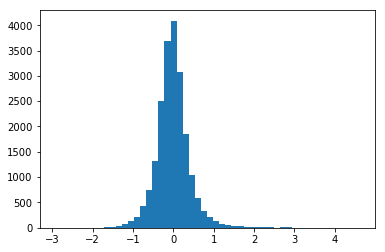

In [49]:
plt.hist(diffs, bins=50);

#### Explore the ratings graph

How many beer ID's are actually the same as user ID's? Because these could mess up graph analysis

In [ ]:
len(set(df.beer_id).intersection(set(df.user_id)))

In [6]:
# switch sign of user ID's so networkx doesn't confuse them with beer ID's
df['neg_user_id'] = -df.user_id 
G = nx.from_pandas_dataframe(df, 'neg_user_id', 'beer_id', edge_attr='rating_user')

In [7]:
CCs = nx.connected_components(G)

In [9]:
type(CCs)

generator

In [10]:
nx.number_connected_components(G)

6

In [11]:
CCsizes = [len(CC) for CC in CCs]
CCsizes

[272515, 2, 3, 2, 2, 3]

Better to just eliminate those 5 homebrew-type connected components so that the main component can be analyzed better.

In [12]:
CCs = nx.connected_components(G)
[CC for CC in CCs if len(CC) < 4]

[{-1073659, 2062392},
 {-6883764, 236187, 3288454},
 {-1911702, 3136176},
 {-472625, 3484065},
 {-783473, 282906, 1072155}]

In [15]:
disconnected = df.set_index('user_id').loc[(1073659, 6883764, 1911702, 472625, 783473), :]

In [16]:
disconnected

,checkin_id,beer_id,rating_user,brewery_name,beer_name,beer_style,brewery_id,brewery_type,brewery_country,brewery_city,...,venue_state,venue_cat,venue_id,checkin_comment,venue_type,rating_global,beer_description,abv,date,neg_user_id
user_id,,,,,,,,,,,,,,,,,,,,,
1073659,450108472,2062392,0.5,Marble Brewery,Pina Pale,Pale Ale - American,825,Regional Brewery,United States,Albuquerque,...,NM,Nightlife Spot,5859322.0,NaN,"['brewery', 'beer_bar', 'beer_garden', 'pub']",NaN,NaN,5.5,2017-05-09 02:44:03+00:00,-1073659
6883764,814644055,3288454,5.0,Mash House Brewing Company,Kilt Smasher BBA,Scotch Ale / Wee Heavy,834,Brew Pub,United States,Fayetteville,...,NaN,NaN,NaN,NaN,[],NaN,NaN,8.0,2019-10-08 00:55:31+00:00,-6883764
6883764,814640718,236187,4.0,Mash House Brewing Company,Oktoberfest,Märzen,834,Brew Pub,United States,Fayetteville,...,NC,Nightlife Spot,28286.0,NaN,"['brewery', 'american_restaurant', 'burger_joi...",NaN,NaN,6.5,2019-10-08 00:45:19+00:00,-6883764
1911702,727497696,3136176,4.0,R.Shea Brewing,Death By Milkshake: Raspberry + Strawberry,IPA - Milkshake,200442,Micro Brewery,United States,Akron,...,OH,Nightlife Spot,3560599.0,NaN,['brewery'],3.90545,New England style IPA with fermented on raspbe...,7.5,2019-03-23 21:52:08+00:00,-1911702
472625,818941280,3484065,5.0,Brewaucracy,Panic Buy (Riwaka),Pale Ale - New Zealand,13426,Micro Brewery,New Zealand,Hamilton,...,Waikato,Nightlife Spot,7414747.0,NaN,['brewery'],4.20833,Anybody for the diesel-like goodness of a sing...,5.5,2019-10-19 02:49:44+00:00,-472625
783473,227845642,1072155,4.0,Taos Mesa Brewing,KNCE,IPA - American,38569,Brew Pub,United States,Taos,...,NaN,NaN,NaN,NaN,[],NaN,NaN,0.0,2015-09-23 01:51:31+00:00,-783473
783473,103495838,282906,5.0,Taos Mesa Brewing,Hopper IPA,IPA - American,38569,Brew Pub,United States,Taos,...,NaN,NaN,NaN,NaN,[],3.49510,This American style IPA has a strong floral no...,7.2,2014-07-31 01:27:58+00:00,-783473


In [17]:
df = df[(df.user_id !=1073659) & (df.user_id !=6883764) &
        (df.user_id !=1911702) & (df.user_id !=472625) & (df.user_id !=783473)]
len(df)

1296057

In [20]:
G = nx.from_pandas_dataframe(df, 'neg_user_id', 'beer_id', edge_attr='rating_user')

In [89]:
bipartite.is_bipartite(G)

NameError: name 'G' is not defined

In [88]:
#  nx.diameter(G)
## Takes too long

In [18]:
bipartite.density(G, df.neg_user_id.unique())

0.0006194297270503944

In [19]:
bipartite.density(G, df.beer_id.unique())

0.0006194297270503944

#### Build graph from scratch for more custom analysis

In [21]:
# clear up some memory
del G

In [22]:
udict = {uid:dict() for uid in df.neg_user_id.unique()}
bdict = {bid:dict() for bid in df.beer_id.unique()}

In [23]:
for checkin in zip(df.neg_user_id, df.beer_id, df.rating_user):
    udict[checkin[0]][checkin[1]] = checkin[2]
    bdict[checkin[1]][checkin[0]] = checkin[2]

In [90]:
bdict[10]

NameError: name 'bdict' is not defined

In [25]:
df[df.beer_id==10]

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,brewery_id,brewery_type,brewery_country,...,venue_state,venue_cat,venue_id,checkin_comment,venue_type,rating_global,beer_description,abv,date,neg_user_id
231947,173111507,10,206343,3.5,Fort Collins Brewery (FCB),Chocolate Stout,Stout - American,545,Micro Brewery,United States,...,NaN,NaN,NaN,NaN,[],3.38719,"A velvety smooth mouthfeel, satisfyingly roast...",5.3,2015-04-16 01:35:20+00:00,-206343
279919,155151913,10,74754,3.0,Fort Collins Brewery (FCB),Chocolate Stout,Stout - American,545,Micro Brewery,United States,...,NaN,NaN,NaN,NaN,[],3.38719,"A velvety smooth mouthfeel, satisfyingly roast...",5.3,2015-02-15 02:06:54+00:00,-74754
1160074,140077209,10,1854202,3.0,Fort Collins Brewery (FCB),Chocolate Stout,Stout - American,545,Micro Brewery,United States,...,NaN,NaN,NaN,NaN,[],3.38719,"A velvety smooth mouthfeel, satisfyingly roast...",5.3,2014-12-24 05:22:14+00:00,-1854202


In [26]:
udict[-206343]

{10: 3.5,
 59: 3.0,
 372: 3.5,
 406: 4.0,
 799: 3.75,
 1070: 3.5,
 1071: 4.0,
 1253: 4.0,
 1382: 4.0,
 1425: 3.5,
 1465: 4.0,
 2178: 3.5,
 2290: 3.5,
 2983: 3.0,
 3111: 3.5,
 3351: 3.5,
 3710: 4.0,
 3770: 3.0,
 3787: 3.0,
 3832: 3.5,
 3919: 4.0,
 3950: 3.5,
 3952: 3.5,
 4136: 4.0,
 4172: 3.5,
 4182: 3.5,
 4538: 3.0,
 4593: 3.5,
 4665: 3.0,
 4863: 4.5,
 4886: 5.0,
 4888: 4.5,
 4997: 3.0,
 5009: 3.5,
 5382: 4.0,
 5406: 3.5,
 5558: 3.5,
 5729: 3.5,
 5756: 4.0,
 5771: 4.0,
 5977: 3.5,
 6102: 3.0,
 6415: 4.0,
 6469: 3.5,
 6727: 3.0,
 6775: 3.0,
 6811: 4.0,
 6857: 4.0,
 6873: 4.0,
 7600: 3.5,
 9251: 3.5,
 9657: 3.5,
 10281: 4.0,
 11950: 3.5,
 12097: 4.0,
 12238: 4.0,
 12560: 3.5,
 12943: 4.0,
 13003: 3.5,
 13105: 3.5,
 13559: 5.0,
 13560: 4.0,
 14814: 3.5,
 17513: 4.0,
 20840: 3.5,
 21004: 3.0,
 23134: 3.5,
 23650: 4.0,
 24943: 3.5,
 26414: 3.5,
 26599: 3.5,
 27915: 3.5,
 29286: 3.0,
 29679: 3.5,
 36012: 4.0,
 36834: 4.0,
 42609: 3.5,
 44575: 3.5,
 45245: 3.5,
 47157: 3.5,
 47515: 4.0,
 5042

#### Make the L-bipartite weighted projection graph:

In [28]:
from collections import defaultdict

# this will show how many in-common beers each user has with 
## each other user who has at least one in common
shared = {u: defaultdict(int) for u in df.neg_user_id.unique()}

# this takes about a minute, with the nested loops, but seems messy otherwise
for u1 in udict:
    # loop thru all checkins by u1
    for b in udict[u1]:
        # mark where a common beer was rated
        for u2 in bdict[b]:
            shared[u1][u2] += 1
    # remove self-edges
    del shared[u1][u1]

len(shared[-206343])

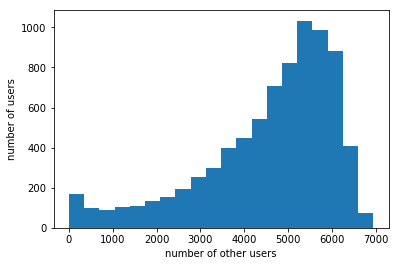

In [61]:
# how many other users have at least 1 rated beer in common with a user
plt.hist([len(shared[user]) for user in shared], bins=20)
plt.xlabel('number of other users')
plt.ylabel('number of users');

In [52]:
# how many shared items with the most similar users
sorted(shared[-206343].values(), reverse=True)[:11]

[27, 27, 23, 23, 16, 16, 15, 14, 13, 13, 13]

A dictionary of dictionaries is kind of overkill here, especially when sorting comes into it, so probably a dictionary of lists of tuples would be more efficient

In [67]:
shared = {u1: sorted([(u2, shared[u1][u2]) for u2 in shared[u1]],
                     key=lambda tup: tup[1], reverse=True) for u1 in shared}


How much harder to make the beer-centric R-bipartite projected weighted graph?

In [71]:
# this will show how many in-common raters each beer has with 
## each other beer that has at least one in common
similars = {b: defaultdict(int) for b in df.beer_id.unique()}

In [72]:
# this takes about 2 minutes, with the nested loops, but seems messy otherwise
for b1 in bdict:
    # loop thru all checkins for b1
    for u in bdict[b1]:
        # mark which others were rated by same user
        for b2 in udict[u]:
            similars[b1][b2] += 1
    # remove self-edges
    del similars[b1][b1]

In [78]:
# how many common raters for a random beer, sorted
sorted(similars[564010].values(), reverse=True)[:22]

[4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2]

At first, random glance, the L-bipartite (User-centric) projection will be more useful, since denser.

In [28]:
reader = Reader(rating_scale=(0.25, 5.0))

### Put this into surprise's format (user, beer, rating)

In [29]:
# The columns must correspond to user_id, beer_id and ratings (in that order).
data = Dataset.load_from_df(df[['user_id', 'beer_id', 'rating_user']], reader)

In [30]:
# define a cross-validation iterator
kf = KFold(n_splits=5)
algo = SVD()


In [33]:

for trainset, testset in kf.split(data):
    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    accuracy.rmse(predictions)

RMSE: 0.4650
RMSE: 0.4650
RMSE: 0.4634
RMSE: 0.4653
RMSE: 0.4633


In [165]:

for trainset, testset in kf.split(data):
    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    accuracy.rmse(predictions)

RMSE: 0.4726
RMSE: 0.4729
RMSE: 0.4733
RMSE: 0.4758
RMSE: 0.4729


In [17]:
predictions[:11]

[Prediction(uid=171496, iid=3034980, r_ui=4.25, est=4.4778698277391804, details={'was_impossible': False}),
 Prediction(uid=1803223, iid=1828774, r_ui=3.25, est=3.5844314206255463, details={'was_impossible': False}),
 Prediction(uid=267320, iid=399609, r_ui=4.0, est=3.981760322915016, details={'was_impossible': False}),
 Prediction(uid=2924460, iid=1187911, r_ui=4.0, est=3.6026735719768013, details={'was_impossible': False}),
 Prediction(uid=1749282, iid=2686615, r_ui=3.5, est=3.6181331817534472, details={'was_impossible': False}),
 Prediction(uid=3292172, iid=3970, r_ui=3.25, est=3.9172385217788266, details={'was_impossible': False}),
 Prediction(uid=4396115, iid=4057, r_ui=4.0, est=3.2826608617101911, details={'was_impossible': False}),
 Prediction(uid=959498, iid=1473393, r_ui=3.5, est=3.6003136089757715, details={'was_impossible': False}),
 Prediction(uid=267320, iid=9681, r_ui=4.0, est=4.3961044757993522, details={'was_impossible': False}),
 Prediction(uid=1279351, iid=647032, r_u

How does that compare to just guessing the global mean rating for every beer?  
First we have to remove the beers that don't have global ratings.  We could  
theoretically use the mean of all user ratings in place of the missing global  
ratings, but for beers with few checkins, that would cheat  
by skewing toward the rating of the user being predicted.

In [21]:
global_rated = df[['rating_user', 'rating_global']]

In [22]:
global_rated.shape

(1296064, 2)

In [98]:
global_rated.max()

rating_user      5.00000
rating_global    4.90672
dtype: float64

In [23]:
global_rated.min()

rating_user      0.25
rating_global    0.00
dtype: float64

Whoops, went to the trouble of setting NaN global ratings to 0.0

In [24]:
# global_rated = global_rated[global_rated.rating_global > 0]

In [25]:
global_rated.shape

(1089604, 2)

In [26]:
global_rated.min()

rating_user      0.25000
rating_global    1.00423
dtype: float64

In [29]:
# calculate the rmse using global rating as prediction
gr = global_rated
diffs = gr.rating_global.values - gr.rating_user.values
sum_errs_sq = np.dot(diffs, diffs)
rmse = np.sqrt(sum_errs_sq / len(diffs))
rmse

0.51243794703341272

So at least the Surprise rmse was lower than that of (the `global_rated` subset of) the whole population.
  
Quick check of what pct of ratings had globals: 

In [109]:
print(f'{round(len(global_rated) * 100 / len(df), 3)} pct of checkins had global ratings.')

84.07 pct of checkins had global ratings.


In [131]:
# might as well keep track of evaluation results
methods = ['naively predict global_mean_rating']
rmses = [0.512]
results = pd.DataFrame({'method': methods,
                        'rmse': rmses})

def add_results_row(meth_name, rmse_result):
    methods.append(meth_name)
    rmses.append(rmse_result)
    results = pd.DataFrame({'method': methods,
                            'rmse': rmses})
    return results

# make sure function works
results = add_results_row('Surprise SVD with default params', 0.474)
results.tail()

,method,rmse
0,naively predict global_mean_rating,0.512
1,Surprise SVD with default params,0.474


In [170]:
# append result rows here and check tail to make sure all good
results = add_results_row('SVD lr=.02 epochs=20 reg=0.1', 0.466)
results.tail()

,method,rmse
0,naively predict global_mean_rating,0.512
1,Surprise SVD with default params,0.474
2,naive mean plus userbias,0.456
3,naive mean plus smart userbias,0.434
4,SVD lr=.02 epochs=20 reg=0.1,0.466


Let's just make sure the error for the testset alone was about the same (.512) as for whole population.

In [112]:
# make a dictionary to map all beer_id's to global ratings, where available
bidrates = df[df.rating_global > 0].groupby('beer_id').rating_global.mean()
bidrates.head()

beer_id
1     3.27892
2     3.49213
8     3.81242
10    3.38719
14    3.77430
Name: rating_global, dtype: float64

In [114]:
dbr = dict(bidrates)  # map beer_id's to glob_ratings

In [123]:
# Now line up all the beers in just the test set,
#   filter out the ones with no global, and put them
#   alongside all their ratings.

globrates = pd.Series([dbr.get(triple[1], 0) for triple in testset])
userrates = pd.Series([triple[2] for triple in testset])
userrates = userrates[globrates > 0]
globrates = globrates[globrates > 0]
# calc rmse
diffs = userrates.values - globrates.values
sum_errs_sq = np.dot(diffs, diffs)
rmse = np.sqrt(sum_errs_sq / len(diffs))
rmse

0.51115640157523945

Let's factor in the user's rating generosity, which should help the naive guess a bit.

In [125]:
# use groupby to get each rater's mean, 
# then use that mapping to add a new column to the end of the df for each checkin
userbias = dict(df.groupby('user_id').rating_user.mean())
df['userbias'] = df.user_id.map(lambda u: userbias[u]) - df.rating_user.mean()

In [129]:
bias_df = df[['rating_user', 'rating_global', 'userbias']]
bias_df = bias_df[bias_df.rating_global > 0]
# add the user's generosity vs the mean
diffs = bias_df.rating_global.values + bias_df.userbias.values - bias_df.rating_user.values
sum_errs_sq = np.dot(diffs, diffs)
rmse = np.sqrt(sum_errs_sq / len(diffs))
rmse

0.45625249039480498

That helped a lot.  A single 'feature' is already better than the Surprise SVD model.
But the calculated userbias is simply how a user rates vis-a-vis the average rating,
and doesn't take into account the fact that certain raters rate higher-rated beers.
If user A lives where beers globally rated 4.5 stars are available, and gives them 4.25 stars,
while user B rates average beers 4.0 where others rated them 3.75, why does user A get
an extra quarter star added to his predictions compared to user B?  I.e. our generosity measure
should maybe account for which beers are being rated.

In [141]:
# for each user, find the difference between their ratings for their beers vs. the world's ratings for same ones
userbeers = dict(userrates.rating_user.mean() - userrates.rating_global.mean())

In [146]:
df['userbeerbias'] = df[df.rating_global > 0].user_id.map(lambda u: userbeers[u])

In [152]:
bias_df = df[['rating_user', 'rating_global', 'userbeerbias']]
bias_df = bias_df[bias_df.rating_global > 0]
# add the user's generosity vs the mean
diffs = bias_df.rating_global.values + bias_df.userbeerbias.values - bias_df.rating_user.values
sum_errs_sq = np.dot(diffs, diffs)
rmse = np.sqrt(sum_errs_sq / len(diffs))
rmse 

0.43369005337892269

That does better.  Let's see if it aligns with Surprise's BaselineOnly model.

In [155]:
baseline = BaselineOnly()

In [156]:
baseline.fit(trainset)

Estimating biases using als...


In [157]:
predictions = baseline.test(testset)
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.4688


0.46881078934132836

hmmmmm, thought that should be 0.434....guess surprise is using estimations where i used actual global ratings.

If Surprise can't keep up with simple baseline predictions, at least while using default parameters, maybe it's time for some GridSearching.

In [ ]:
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.001, 0.002, 0.005, 0.01],
              'reg_all': [0.2, 0.5, 1.0, 2.0]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

In [164]:
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.470300063255
{'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}


Not much improvement there from the default params (.474 improved to .470), but since the best  
params out of the grid were all at the end of the param range (15 epochs was the most in the grid,  
0.01 was the highest learning rate, and 0.2 was the lowest regularization), let's try fitting  
with the next step out in the directions of those params.


In [166]:
algo = SVD(lr_all=0.02, n_epochs=20, reg_all=0.1, verbose=True)
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [167]:
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.4664


0.46640651047237058

Better than 0.470, so keep trying, with higher step rate, and lower regularization, until things reverse.

In [169]:
algo = SVD(lr_all=0.03, n_epochs=20, reg_all=0.05, verbose=True)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.4683


0.46830288741631865

That didn't take long.  So store the best params from previous fit into the results table.

In [173]:
sim_options = {'name': 'pearson'}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
preds = algo.test(testset)
accuracy.rmse(preds)

Computing the pearson similarity matrix...


/Applications/anaconda/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in sqrt
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 0.5886


0.58863602712876439

How do individual user tastes determine which features correlate with ratings?

In [174]:
df.columns

Index(['checkin_id', 'beer_id', 'user_id', 'rating_user', 'brewery_name',
       'beer_name', 'beer_style', 'brewery_id', 'brewery_type',
       'brewery_country', 'brewery_city', 'brewery_state', 'brewery_lat',
       'brewery_lon', 'venue_lat', 'venue_lon', 'venue_city', 'venue_country',
       'venue_state', 'venue_cat', 'venue_id', 'checkin_comment', 'venue_type',
       'rating_global', 'beer_description', 'abv', 'date', 'userbias',
       'userbeerbias'],
      dtype='object')

In [175]:
df.shape

(1296064, 29)

===========================================================================================================

In [177]:
no_globs = df[df.rating_global == 0]
no_globs.shape

(2519, 29)

In [189]:
null_globs = df[df.rating_global.isnull()]

len(null_globs)

In [191]:
null_globs.beer_id.nunique()

128147

In [187]:
null_globs[:11]

array([3314111, 2222682,  501186, 2139385, 2319561, 1509915, 2616033,
       2612066, 2515216, 2413550,  526725])

In [188]:
df.beer_id.nunique()  # so half the beers don't have globrates

264620

In [192]:
globs = df[df.rating_global.notnull()]

In [193]:
len(globs)

1092123

In [194]:
len(null_globs)

203941

In [195]:
null_ids = set(null_globs.beer_id)
glob_ids = set(globs.beer_id)

overlaps = null_ids.intersection(glob_ids)

In [197]:
len(overlaps)

0

================================================================================================================

Data splitter for cross-validation

In [91]:
def make_splits(df, folds, seed=0):
    from random import shuffle, seed
    seed(seed)
    inds = list(df.index)
    shuffle(inds)
    foldsize = len(inds) // folds
    indexlist = []
    for f in range(folds):  # tuples of (train_inds, test_inds)
        indexlist.append((inds[:f*foldsize] + inds[(f+1)*foldsize:],
                        inds[f*foldsize:(f+1)*foldsize]))
    return indexlist

In [92]:
splitdf = make_splits(df, 5)

Let's try the splitter out on some cross-validation for baseline ratings

In [125]:
lam_2 = 5  # regularizer for baseline stats.  higher makes for less baselining
lam_3 = 10
#  see:  http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
rmses = []  # accumulate the cross-val scores here
for batch in splitdf:
    # use the splits to cross-val
    train_data = df.loc[batch[0], :]
    val_data = df.loc[batch[1], :]
    train_mu = train_data.rating_user.mean()  # average rating for the checkins in this dataset
    
    by_beer = train_data.groupby('beer_id')
    beer_bias = dict((by_beer.rating_user.sum() - by_beer.size() * train_mu) /
                    (lam_2 + by_beer.size()))
    train_data['bbias'] = train_data.beer_id.map(lambda x: beer_bias[x])
    
    by_user = train_data.groupby('user_id')
    user_bias = dict((by_user.rating_user.sum() - by_user.size() * train_mu - by_user.bbias.sum()) /
                     (lam_3 + by_user.size()))
    
    val_data['bbias'] = val_data.beer_id.apply(lambda x: beer_bias[x] if x in beer_bias else np.nan)
    val_data['ubias'] = val_data.user_id.apply(lambda x: user_bias[x] if x in user_bias else np.nan)
    val_data.dropna(subset=['bbias','ubias'], axis=0, inplace=True)
    
    test_preds = val_data.bbias.values + val_data.ubias.values + train_mu
    actuals = val_data.rating_user.values
    diffs = test_preds - actuals
    sum_errs_sq = np.dot(diffs, diffs)
    rmse = np.sqrt(sum_errs_sq / len(diffs))
    print(rmse)
    rmses.append(rmse)

0.454955347077
0.455823411606
0.456049159322
0.45569594223
0.454757755827


lambda_2 = 5 and lambda_3 = 10 had as good of results as any combo (5 and 5 was same)

====================================================================================================================

### Random Aside:  
Should've split the "beer_description" column off from the rest of the data long ago, since it takes up the bulk of the memory and hasn't been part of most of the analysis so far.

In [23]:
!ls -l bigframe.csv

-rw-r--r--  1 ethanhaley  staff  673417511 Dec  5 17:35 bigframe.csv


In [24]:
df = pd.read_csv('bigframe.csv')

In [27]:
df.beer_description[:5]

0    To create a recipe so tropical and fruity with...
1                                                  NaN
2    NEW TRADITIONS CALL FOR NEW HOLIDAYS AND NEW H...
3    Stone Ruination IPA was the first full-time br...
4    Made with Highly roasted malted barley, and pl...
Name: beer_description, dtype: object

In [29]:
description = pd.DataFrame({'beer_id': df.beer_id, 'beer_description': df.beer_description})

In [30]:
description.shape

(1425447, 2)

In [31]:
description.to_csv('descriptions.csv')

In [32]:
!ls -l descriptions.csv

-rw-r--r--  1 ethanhaley  staff  304210897 Dec 31 09:25 descriptions.csv


In [34]:
df.drop('beer_description', axis=1, inplace=True)
df.columns

Index(['checkin_id', 'beer_id', 'user_id', 'rating_user', 'brewery_name',
       'beer_name', 'beer_style', 'brewery_id', 'brewery_type',
       'brewery_country', 'brewery_city', 'brewery_state', 'brewery_lat',
       'brewery_lon', 'venue_lat', 'venue_lon', 'venue_city', 'venue_country',
       'venue_state', 'venue_cat', 'venue_id', 'checkin_comment', 'venue_type',
       'rating_global', 'abv', 'date'],
      dtype='object')

In [35]:
df.shape

(1425447, 26)

In [36]:
df.to_csv('bigframe.csv')

In [4]:
!ls -l bigframe.csv

-rw-r--r--  1 ethanhaley  staff  394024415 Dec 31 09:38 bigframe.csv


============================================================================================================